# Introduction

Climate indices are known to influence the global climate and even weather pattern. In this analysis, I want to display some of the potentials of using climate indices in predicting food price.

### Data used:

FAO Food Price Index: https://www.fao.org/worldfoodsituation/foodpricesindex/en/

ONI index: https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt


### Purpose:

To understand the trend of food price trend, and also dig into the relationship between ENSO and the food price.


In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import scipy

## FAO Food Price Indices

For FAO Food indices, data are normolized compared to the price of 2014 to 2016. The value of 100 means it is the same price as 2014 to 2016, where higher means more expensive. 

As for "Food Price Index", it is the weighted average of all common food type.

Several things we can observe:
1. The inflation exist. This may influence our analysis.
2. There are several big price fluctuation, most of them related to big economic events (e.g. 2008 and 2021).
3. Suger and oils are having more fluctuation relatively.

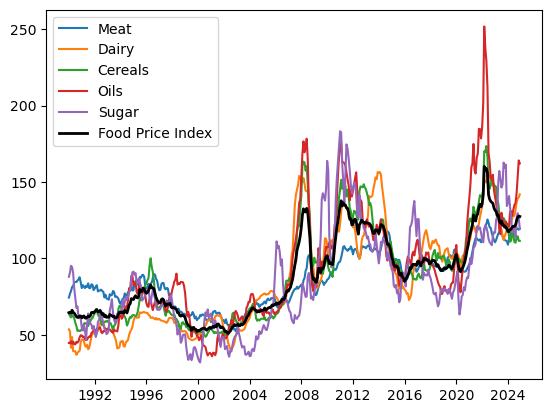

In [2]:
#loading FAO food indices
Foodprice=pd.read_csv('food_price_indices_data.csv',header=2)
Foodprice.drop(0,inplace=True)
Foodprice.reset_index(drop=True,inplace=True)
datelist=[]
for year in range(1990,2025):
    for month in range(1,13):
        datelist.append(date(year,month,1))

fig,ax=plt.subplots()
for fooddata in range(2,7):
    ax.plot(datelist,Foodprice.iloc[:-3,fooddata],label=Foodprice.columns[fooddata])
ax.plot(datelist,Foodprice.iloc[:-3,1],label=Foodprice.columns[1],linewidth=2,color='black')
ax.legend(loc=0)
plt.show()

In order to solve the inflation problem, here I use the moving average and the price difference between moving average (3 years) to extract the data. The plot below shows the food price indices difference between moving average. The same conclusion holds for the plot above, but this one does not have the obvious inflation.

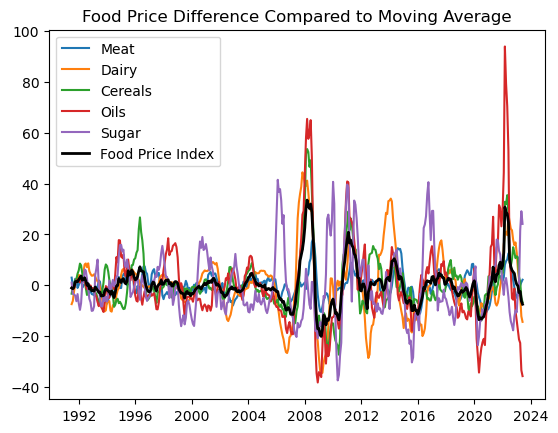

In [3]:
#plotting foodprice difference compared to 3-year moving average

fooddiff=Foodprice.iloc[:-3,1:7]-Foodprice.iloc[:-3,1:7].rolling(37,center=True).mean()

fig,ax=plt.subplots()
for fooddata in range(2,7):
    ax.plot(datelist,Foodprice.iloc[:-3,fooddata]-Foodprice.iloc[:-3,fooddata].rolling(37,center=True).mean(),label=Foodprice.columns[fooddata])
ax.plot(datelist,Foodprice.iloc[:-3,1]-Foodprice.iloc[:-3,1].rolling(37,center=True).mean(),label=Foodprice.columns[1],linewidth=2,color='black')
ax.legend(loc=0)
ax.set_title('Food Price Difference Compared to Moving Average')
plt.show()

## ONI

ONI is the short term of Oceanic Nino Index, which is the sea surface temperature anomaly of the Equatorial region of Pacific Ocean. ONI is one of the most common method to determine El Nino, La Nina or neutral years. There are several different definitions, but to simplify, here I define El Nino as ONI>0.5 and La Nina as ONI<-0.5, where ONI in between are neutral years.

We can observe several things:
1. Each El Nino years could have around 2 to 6 years intervals, and the same as La Nina years.
2. Sometimes El Nino/La Nina events can hold up to several years. One of a good example is the La Nina event happened in 2021 to 2023.
3. El Nino/La Nina events are known as "hard to predict". It is hard to predict the upcoming events based on timeseries.

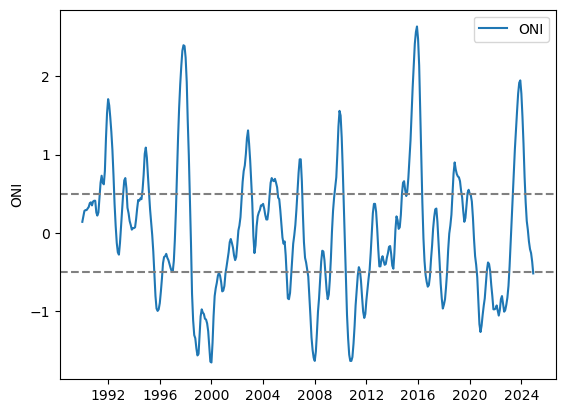

In [4]:
ONI=pd.read_fwf('ONI.txt')
ONI=ONI.loc[ONI['YR']>=1990]
ONI.reset_index(drop=True,inplace=True)

fig,ax=plt.subplots()
ax.plot(datelist,ONI.iloc[:-2,3],label='ONI')
ax.axhline(y=0.5,linestyle='--',color='grey')
ax.axhline(y=-0.5,linestyle='--',color='grey')
ax.set_ylabel('ONI')
ax.legend()
plt.show()

## Exploring relationship between food price indices and ONI and lagged ONI

Here I use scatter plots to explore the relationship between ONI and food price. In order to see if there are any lagged effect of ONI to food price, I also plotted lag 3, 6, 9-month ONI on food price indices.

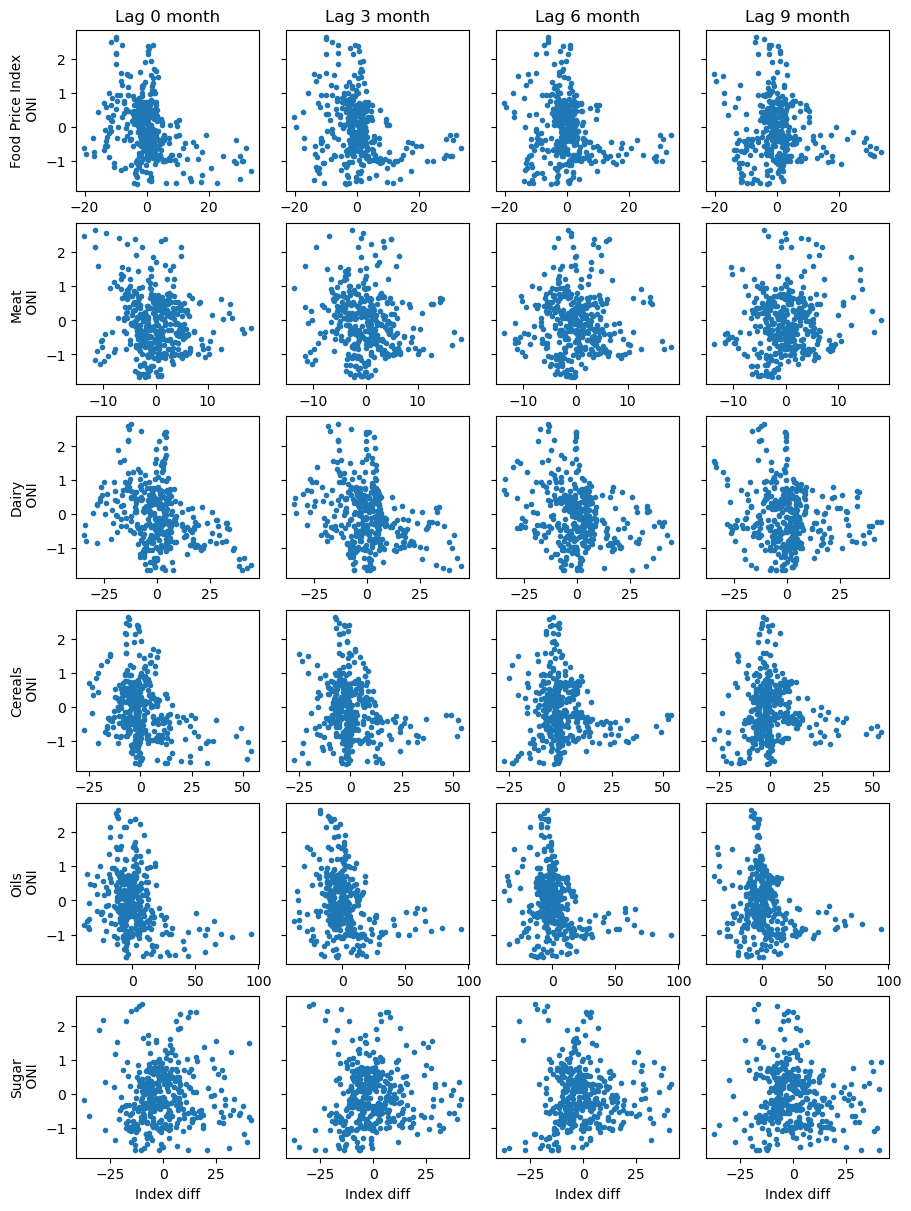

In [5]:
# scatter plots of each food price indices diff and lag 0,3,6,9 month of ONI
fig,ax=plt.subplots(6,4,figsize=(9,12),layout='constrained',sharey=True)
for fooddata in range(6):
    for lag in range(4):
        ax[fooddata,lag].scatter(fooddiff.iloc[18:-18-lag*3,fooddata].values,ONI.iloc[18+lag*3:-20,3].values,marker='.')
        if fooddata==0:
            ax[fooddata,lag].set_title('Lag '+str(lag*3)+' month')
        if lag==0:
            ax[fooddata,lag].set_ylabel(fooddiff.columns[fooddata]+'\n ONI')
        if fooddata==5:
            ax[fooddata,lag].set_xlabel('Index diff')
plt.show()

Several things we can observe:
1. Extreme value (price diff >25% and <-25%) exist and may skew the analysis.
2. Except sugar and meat, food price almost have no big price increase (>+10%) during El Nino phase.
3. Lagged effect of ONI seems do not increase the relationsip between food price that much.

In order to understand the detail statistics, here I plotted the correlation of each lagged month (lag 0, 3, 6, 9-months) ONI and each food indices.

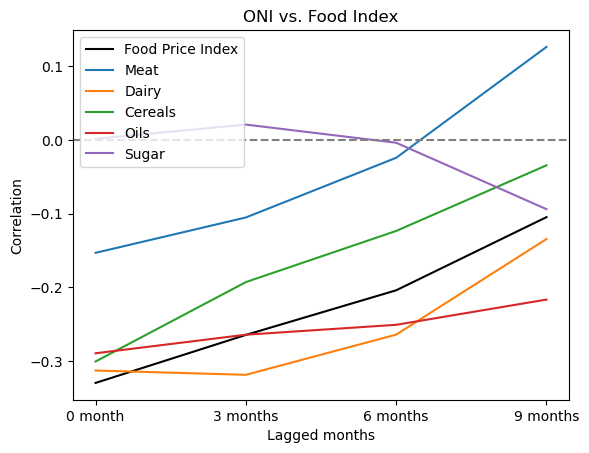

In [7]:
fig,ax=plt.subplots()
for fooddata in range(6):
    corr=[]
    for lag in range(4):
        corr.append(np.corrcoef(fooddiff.iloc[18:-18-lag*3,fooddata].values,ONI.iloc[18+lag*3:-20,3].values)[1,0])
    if fooddata==0:
        ax.plot(corr,label=fooddiff.columns[fooddata],color='black')
    else:
        ax.plot(corr,label=fooddiff.columns[fooddata])
ax.set_xticks([0,1,2,3],['0 month','3 months','6 months','9 months'])
ax.set_xlabel('Lagged months')
ax.set_ylabel('Correlation')
ax.set_title('ONI vs. Food Index')
ax.axhline(y=0,linestyle='--',color='grey')
ax.legend(loc=2)
plt.show()

From this plot, several things we can conclude:
1. Except sugar, all food type (including weighted-average index) have negative correlation with ONI (no lagged). This means higher ONI could lead to lower food price.
2. When lagged time increases, correlation between food price generally dropped. Only two exceptions: sugar, and dairy's correlation between no lag and lagged 3-month ONI. Oils' correlation almost hold the same from lagged 0 month to 6 months.
3. Having still around -0.3 correlation using lagged 3-month ONI actually means there are some predictibility. This may benefit in real world applications.


## Insights

1. Food price itself has inflation and flactuation due to economical impact.
2. ONI has negative correlation to food price indices, except sugar.
3. Lagged ONI also have negative correlation, which can hold up to 6 months in some food type.

## Possible Next Steps

1. Method to remove inflation can be optimized.
2. Seperating El Nino/La Nina condition for further analysis.
3. Identify the extreme values and decide whether to remove for further analysis.
4. From previous experience, ONI can influence local weather pattern. Can analyze local food price (by interest).